In [66]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation


#plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

np.set_printoptions(linewidth=100)


In [67]:
import pandas as pd

In [68]:
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()
tempdir

<TemporaryDirectory 'C:\\Users\\zhuan\\AppData\\Local\\Temp\\tmp08ydtr4r'>

In [69]:
def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

# KTO Weak Link on the left

## Define Device

In [73]:
length_units = "um"
# Material parameters
xi = 0.02
london_lambda = 3
d = 0.008
# Device geometry
total_width = 0.4
total_length = 1.1
# link_width = total_width / 2
# Outer geometry of the film
right_notch = (
    tdgl.Polygon(points=box(total_width,10*xi))
    .rotate(0)
    .translate(dx=2.65 * xi + 0.002)
)
left_notch = (
    tdgl.Polygon(points=box(total_width,10*xi))
    .rotate(0)
    .translate(dx=-total_width + 0.002)
)
# right_notch = left_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(right_notch)
    .difference(left_notch)
    .resample(401)#resample vertices so that they are approximately uniformly distributed along the polygon boundary
    .buffer(0)
)
source = (
    tdgl.Polygon("source", points=box(.55 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(total_width/2-xi, total_length/2-3*xi), (total_width/2-xi, -total_length/2+3*xi)
                # ,(total_width/2-xi, total_length/2-3*xi), (total_width/2-xi, -total_length/2+3*xi)
                ]

In [74]:
layer1 = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=0.0, u=5.79)
device1 = tdgl.Device(
    "rectangle1",
    layer=layer1,
    film=film,
    #holes=[round_hole, square_hole],
    terminals=[source, drain],
    probe_points=probe_points,
    length_units=length_units,
)

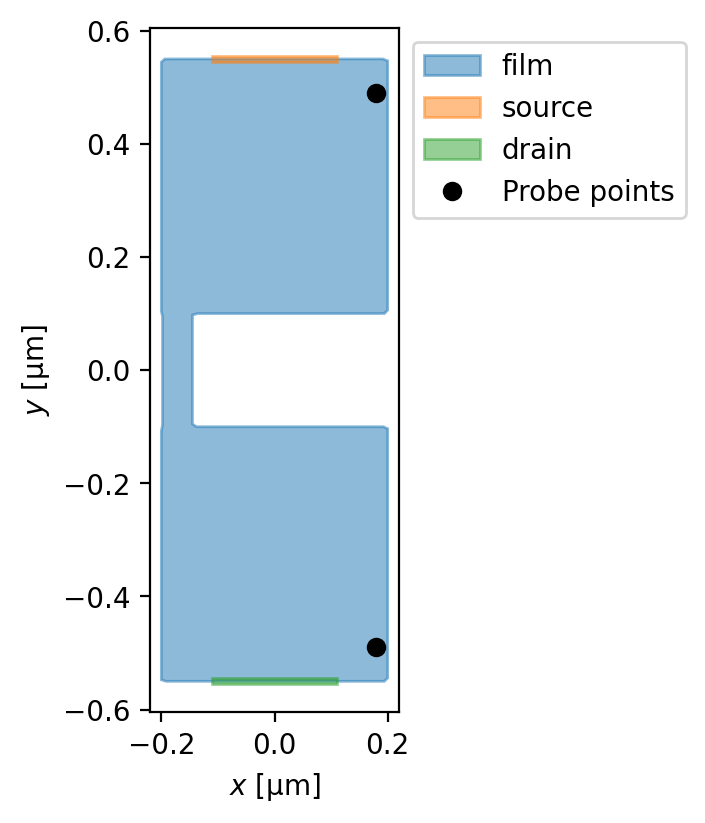

In [75]:
fig, ax = device1.draw()

In [76]:
device1.make_mesh(max_edge_length=0.75*xi , smooth=50)

Constructing Voronoi polygons: 100%|██████████| 5575/5575 [00:02<00:00, 2763.88it/s]


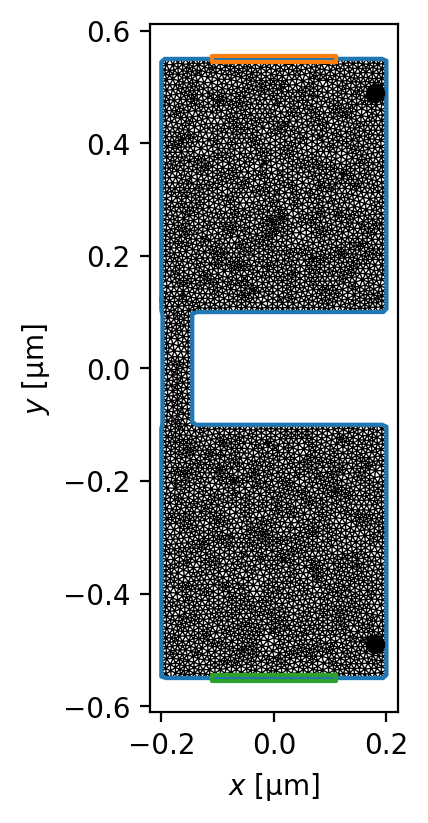

In [77]:
fig, ax = device1.plot(mesh=True, legend=False)
#_ = ax.set_ylim(-7, 7)

In [78]:
device1.mesh_stats()

## Solve for one current value

### Define Disorder

In [79]:
def dis(loc):
    # x,y=loc
    # if y < 5 * xi and y > -5 * xi:
    #     return .9
    return 1

In [80]:
options = tdgl.SolverOptions(
    skip_time = 500,
    solve_time = 500,
    output_file = os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 150
)

solution1 = tdgl.solve(
    device1,
    options,
    terminal_currents=dict(source = .19, drain = -.19),
    applied_vector_potential = 175,
    disorder_epsilon = 1
)

Simulating: 100%|█████████▉| 500/500 [01:45<00:00,  4.74tau/s ]


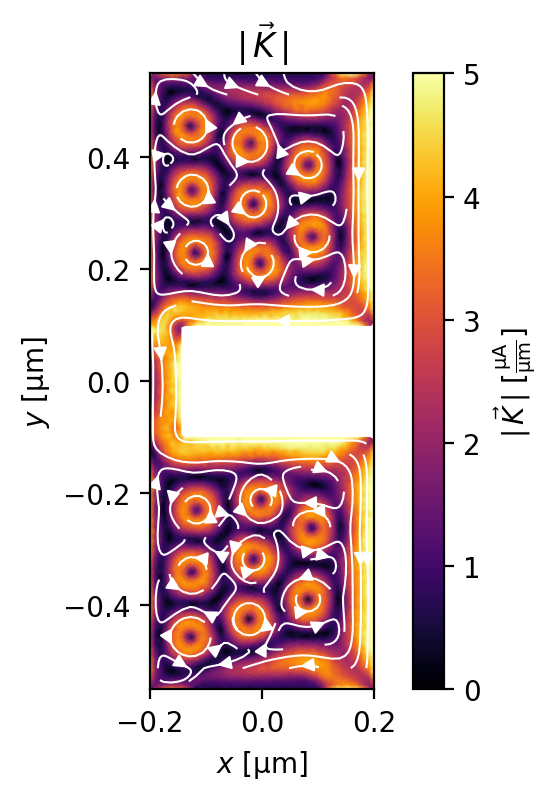

In [81]:
fig, ax = solution1.plot_currents(min_stream_amp = 0.02, vmin = 0, vmax = 5)

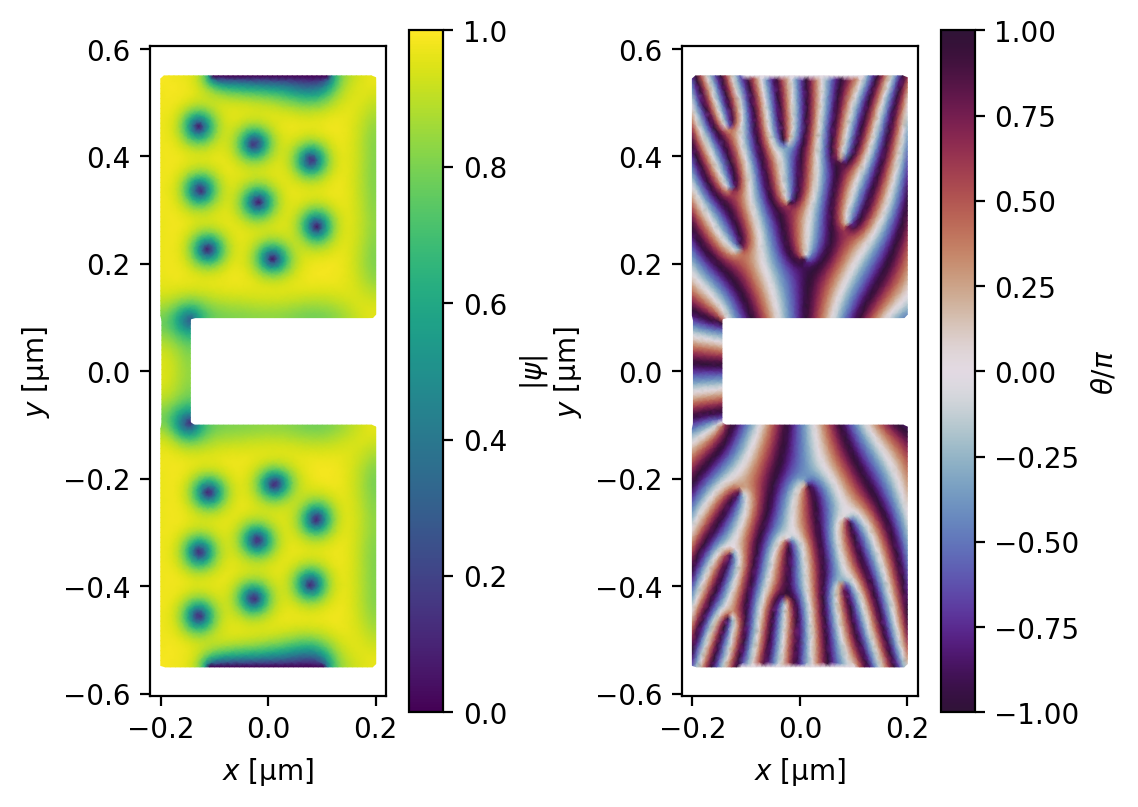

In [82]:
t0 = 100
solution1.solve_step = solution1.closest_solve_step(t0)
fig, axes = solution1.plot_order_parameter(figsize = (5.5, 4))

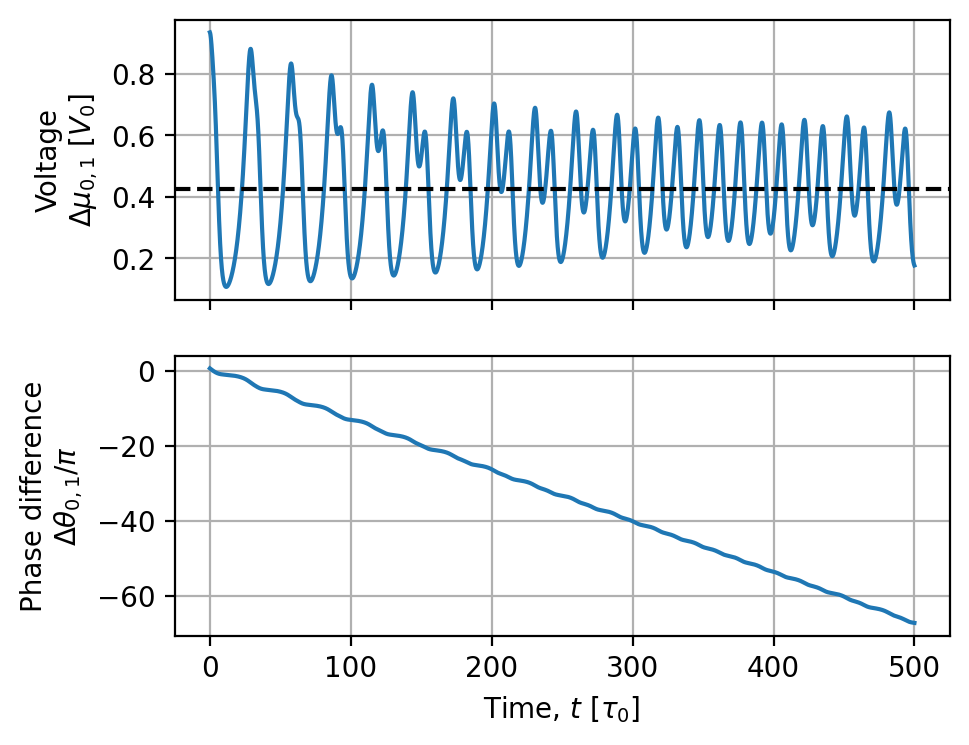

In [83]:
dynamics = solution1.dynamics
fig, axes = dynamics.plot()

In [84]:
dynamics.voltage().mean()

0.4460127089228895

In [85]:
if MAKE_ANIMATIONS:
    video1 = make_video_from_solution(
        solution1,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video1)

## Reverse field

In [86]:
options = tdgl.SolverOptions(
    skip_time = 500,
    solve_time = 500,
    output_file = os.path.join(tempdir.name, "weak-link-500oe-field.h5"),
    field_units = "mT",
    current_units = "uA",
    save_every = 150
)

solution1 = tdgl.solve(
    device1,
    options,
    terminal_currents=dict(source = .19, drain = -.19),
    applied_vector_potential = -175,
    disorder_epsilon = 1
)

Simulating: 100%|█████████▉| 500/500 [00:13<00:00, 37.45tau/s ]


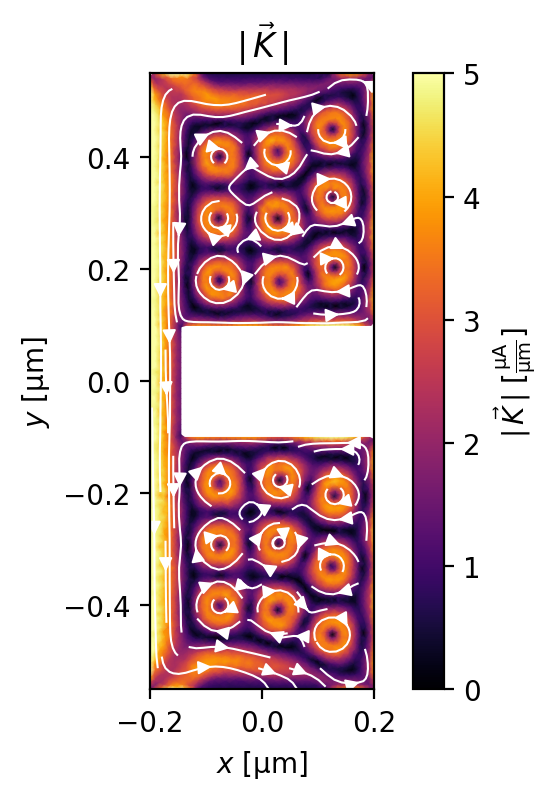

In [87]:
fig, ax = solution1.plot_currents(min_stream_amp = 0.075, vmin = 0, vmax = 5)

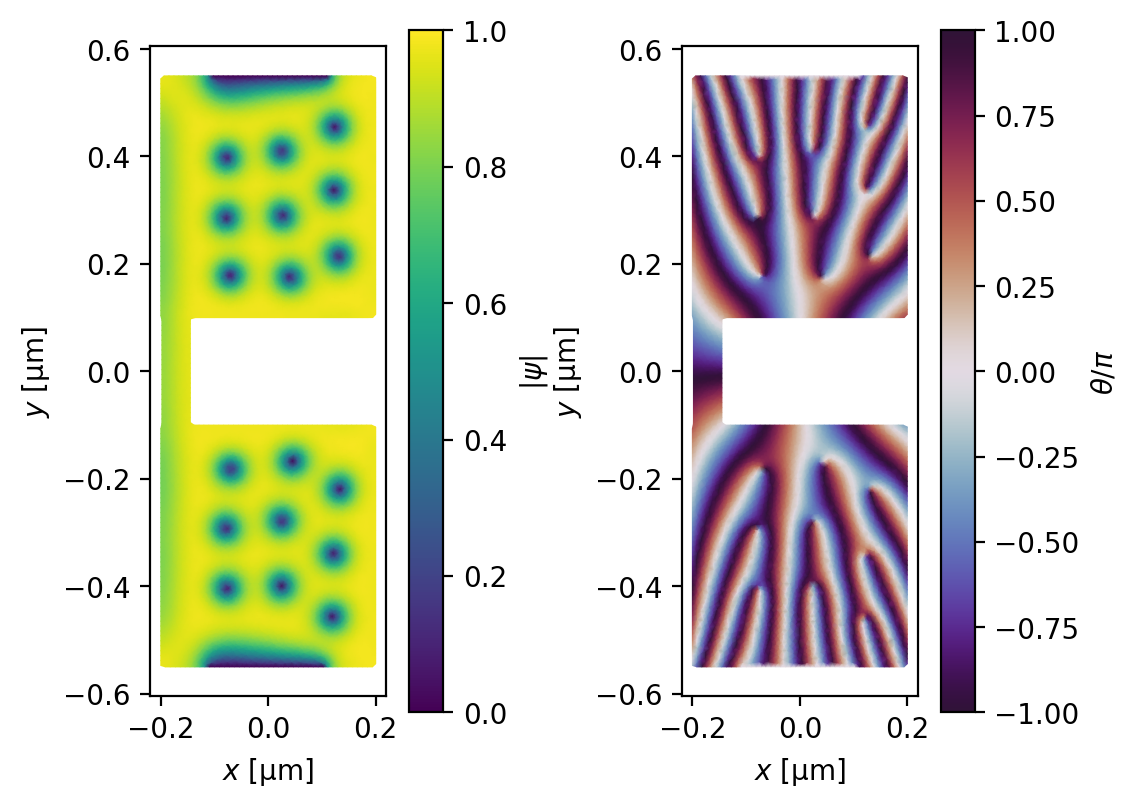

In [88]:
t0 = 100
solution1.solve_step = solution1.closest_solve_step(t0)
fig, axes = solution1.plot_order_parameter(figsize = (5.5, 4))

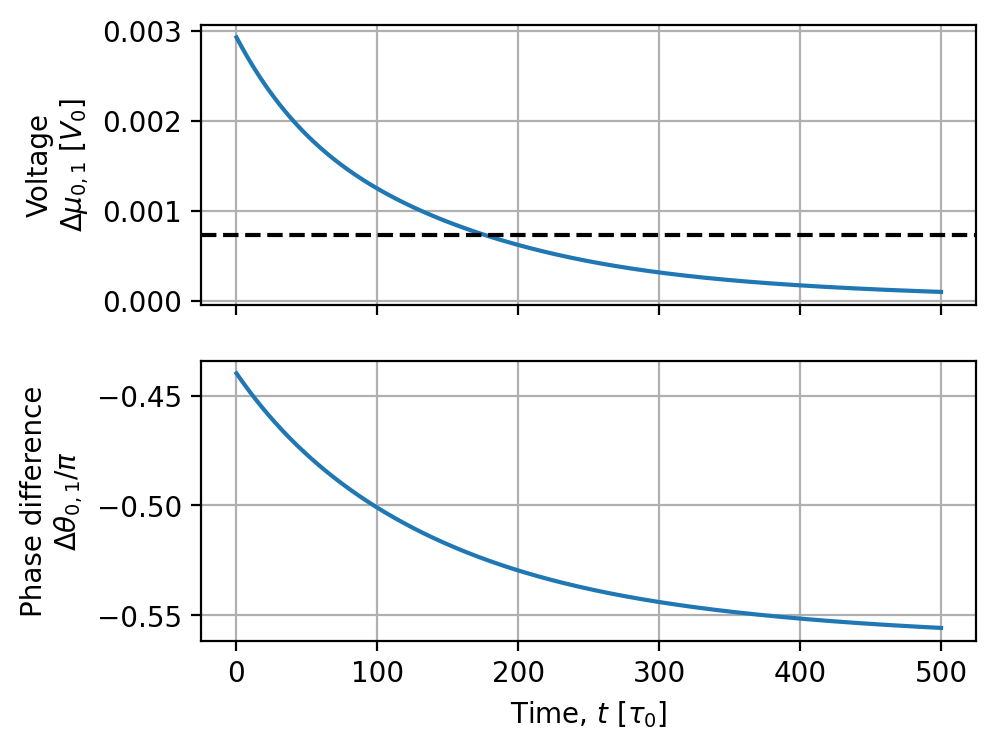

In [89]:
dynamics = solution1.dynamics
fig, axes = dynamics.plot()

In [90]:
if MAKE_ANIMATIONS:
    video1 = make_video_from_solution(
        solution1,
        quantities=['order_parameter', 'phase', 'scalar_potential'],
        figsize=(6.5, 4)
    )
    display(video1)

## Sweep B and current, save the calculated mean voltage in a dataframe

In [25]:
current_list = np.append(np.linspace(-0.03, -0.21, 121), 0)
current_list = np.append(current_list, np.linspace(0.03, 0.21, 121))
VvsIvsB = pd.DataFrame({'current':current_list})

for B in range(-600, 605, 25):
    voltage_list = np.array([])

    options0 = tdgl.SolverOptions(
        skip_time = 150,
        solve_time = 90,
        output_file = os.path.join(tempdir.name, f"left-thin-weak-link-{B}oe-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = 500
    )

    seed_solution = tdgl.solve(
        device1,
        options0,
        terminal_currents=dict(source = current_list[0], drain = -current_list[0]),
        applied_vector_potential = B,
        disorder_epsilon = dis,
    )

    options1 = tdgl.SolverOptions(
        skip_time = 60,
        solve_time = 90,
        output_file = os.path.join(tempdir.name, f"left-thin-weak-link-{B}oe-field.h5"),
        field_units = "mT",
        current_units = "uA",
        save_every = 300
    )

    for current in current_list:
        if current == 0:
            solution = tdgl.solve(
                device1,
                options0,
                terminal_currents=dict(source = 0, drain = 0),
                applied_vector_potential = B,
                disorder_epsilon = dis,
            )
        else:
            solution = tdgl.solve(
                device1,
                options1,
                terminal_currents=dict(source = current, drain = -current),
                applied_vector_potential = B,
                disorder_epsilon = dis,
                seed_solution = seed_solution
            )
        mean_voltage = solution.dynamics.voltage().mean()
        voltage_list = np.append(voltage_list, mean_voltage)
        seed_solution = solution
    
    VvsIvsB[str(B)] = voltage_list

VvsIvsB.set_index('current', inplace = True)
VvsIvsB.sort_index(inplace=True, ascending=True)

Simulating: 100%|█████████▉| 90/90 [00:03<00:00, 25.57tau/s ]
Output file already exists. Renaming to C:\Users\zhuan\AppData\Local\Temp\tmp5l5fy9r6\left-thin-weak-link--600oe-field-1.h5.
Simulating: 100%|█████████▉| 90/90 [00:02<00:00, 36.15tau/s ]
Output file already exists. Renaming to C:\Users\zhuan\AppData\Local\Temp\tmp5l5fy9r6\left-thin-weak-link--600oe-field-2.h5.
Simulating: 100%|█████████▉| 90/90 [00:01<00:00, 47.12tau/s ]
Output file already exists. Renaming to C:\Users\zhuan\AppData\Local\Temp\tmp5l5fy9r6\left-thin-weak-link--600oe-field-3.h5.
Simulating: 100%|█████████▉| 90/90 [00:02<00:00, 37.02tau/s ]
Output file already exists. Renaming to C:\Users\zhuan\AppData\Local\Temp\tmp5l5fy9r6\left-thin-weak-link--600oe-field-4.h5.
Simulating: 100%|█████████▉| 90/90 [00:02<00:00, 43.26tau/s ]
Output file already exists. Renaming to C:\Users\zhuan\AppData\Local\Temp\tmp5l5fy9r6\left-thin-weak-link--600oe-field-5.h5.
Simulating: 100%|█████████▉| 90/90 [00:02<00:00, 35.47tau/s ]
Out

In [93]:
VvsIvsB=pd.read_csv('left-thin-weak-link-VvsIvsB-new3.csv')

In [94]:
VvsIvsB.set_index('current', inplace = True)

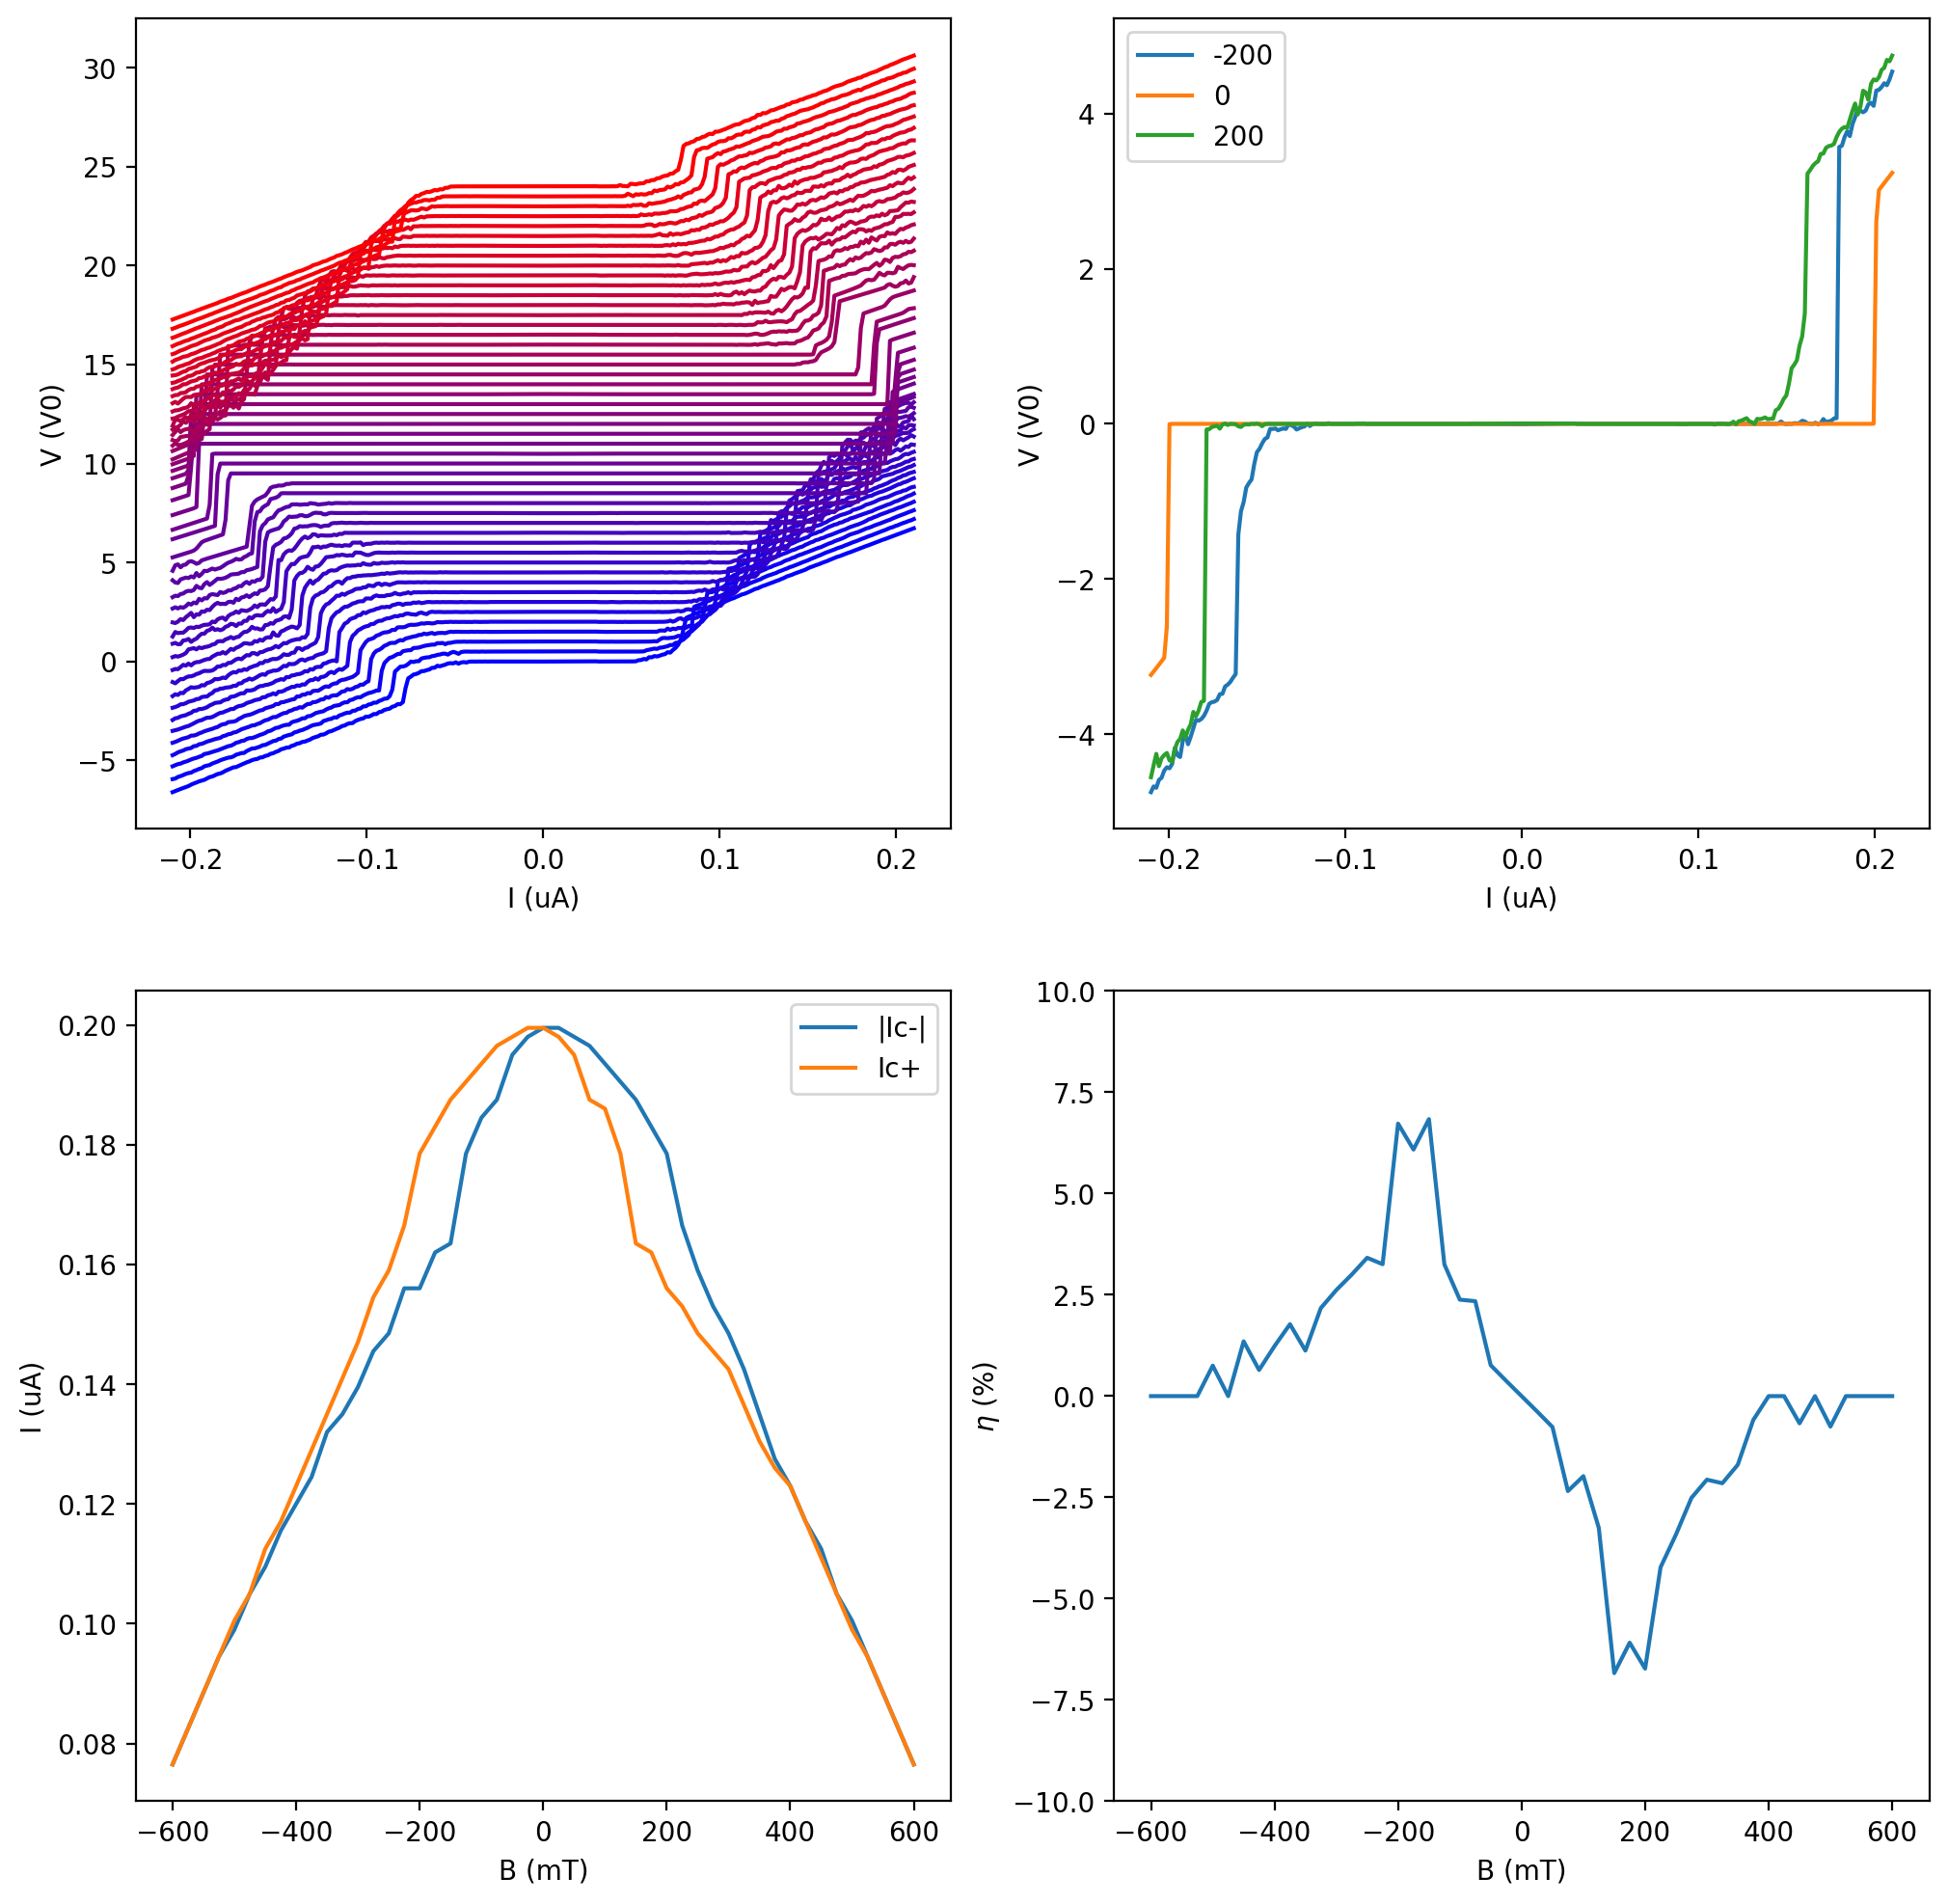

In [95]:
fig, axes = plt.subplots(2, 2, figsize = (12, 12))
Icm_list = np.array([])
Icp_list = np.array([])
B_list = np.array([])

for i, B in enumerate(VvsIvsB.columns[::]):
    VvsI = VvsIvsB[B]
    for I in VvsI.index:
        if VvsI.loc[I] > -1:
            Icm = I
            break
    for I in VvsI.index[::-1]:
        if VvsI.loc[I] < 1:
            Icp = I
            break
    B_list = np.append(B_list, int(B))
    Icm_list = np.append(Icm_list, Icm)
    Icp_list = np.append(Icp_list, Icp)
    axes[0][0].plot(VvsI.index, VvsI.values + 0.5 * i, label = B + ' mT', color = [i / 48, 0, 1- i /48])
axes[0][0].set_xlabel('I (uA)')
axes[0][0].set_ylabel('V (V0)')

axes[0][1].plot(VvsIvsB.iloc[::, 16], label = VvsIvsB.columns[16])
axes[0][1].plot(VvsIvsB.iloc[::, 24], label = VvsIvsB.columns[24])
axes[0][1].plot(VvsIvsB.iloc[::, -17], label = VvsIvsB.columns[-17])
axes[0][1].set_xlabel('I (uA)')
axes[0][1].set_ylabel('V (V0)')
axes[0][1].legend()

axes[1][0].plot(B_list, -Icm_list, label = '|Ic-|')
axes[1][0].plot(B_list, Icp_list, label = 'Ic+')
axes[1][0].set_xlabel('B (mT)')
axes[1][0].set_ylabel('I (uA)')
axes[1][0].legend()

axes[1][1].plot(B_list, (Icp_list+Icm_list) / (Icp_list-Icm_list) * 100)
axes[1][1].set_ylim([-10, 10])
axes[1][1].set_xlabel('B (mT)')
axes[1][1].set_ylabel('$\eta$ (%)')

VvsIvsB.to_csv('left-thin-weak-link-VvsIvsB-new3.csv')

In [97]:
import plotly.express as px
fig = px.imshow(VvsIvsB, color_continuous_scale = 'RdBu')
fig.update_layout(width = 600, xaxis_title = 'B (mT)')
fig.show()